<a href="https://colab.research.google.com/github/HMRLKE/torch-dreams/blob/master/BSCV_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch-dreams  --upgrade
#!pip install opencv-python  --upgrade
# last tested version: torch-dreams 2.3.2

In [2]:
from google.colab import drive
import sys
import os
import torch

drive.mount('/content/drive')
sys.path.append('/content/drive')
path = "/content" # /content is pretty much the root. you can choose other path in your colab workspace
os.chdir(path)
%cd drive/MyDrive/biggan
#%ls

Mounted at /content/drive
/content/drive/MyDrive/biggan


In [3]:
!wget -O imagenet_classes.pkl "https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl"
## loads up imagenet classes into a dictionary
import pickle
with open('imagenet_classes.pkl', 'rb') as f:
    imagenet_class_names = dict(pickle.load(f))
print(imagenet_class_names)


--2023-08-22 11:33:51--  https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35454 (35K) [text/plain]
Saving to: ‘imagenet_classes.pkl’

imagenet_classes.pk 100%[===================>]  34.62K  --.-KB/s    in 0.003s  

2023-08-22 11:33:51 (12.2 MB/s) - ‘imagenet_classes.pkl’ saved [35454/35454]

{0: 'tench, Tinca tinca', 1: 'goldfish, Carassius auratus', 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 3: 'tiger shark, Galeocerdo cuvieri', 4: 'hammerhead, hammerhead shark', 5: 'electric ray, crampfish, numbfish, torpedo', 6: 'stingray', 7: 'cock', 8: 'hen', 9: 'ostrich, Struthio ca

--2023-08-21 09:38:14--  https://cdn.hackaday.io/images/1219231493836853483.jpg
Resolving cdn.hackaday.io (cdn.hackaday.io)... 3.162.174.69, 3.162.174.59, 3.162.174.106, ...
Connecting to cdn.hackaday.io (cdn.hackaday.io)|3.162.174.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15881 (16K) [image/jpeg]
Saving to: ‘elephant.jpg’

elephant.jpg        100%[===================>]  15.51K  --.-KB/s    in 0s      

2023-08-21 09:38:14 (87.6 MB/s) - ‘elephant.jpg’ saved [15881/15881]



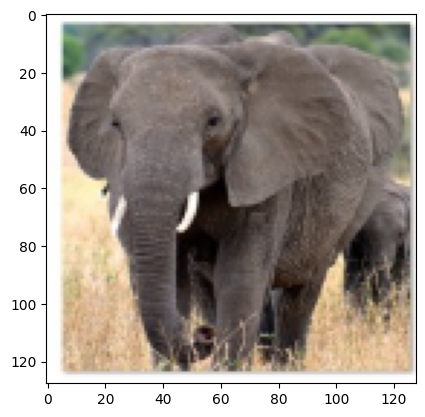

NameError: ignored

In [4]:
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
from torch_dreams.dreamer import Dreamer
from torch_dreams.model_bunch import ModelBunch



!wget -O elephant.jpg "https://cdn.hackaday.io/images/1219231493836853483.jpg"
im_original = cv2.cvtColor(cv2.imread('elephant.jpg'), cv2.COLOR_BGR2RGB)/255.
im_original = cv2.resize(im_original, (128,128))  ## resize to a smaller size for faster computations
im = im_original
height , width , channels = im.shape
plt.imshow(im)
plt.show()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image_tensor = torch.tensor(im).permute(-1,0,1).unsqueeze(0)
t = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

image_tensor_transformed = t(image_tensor).to(device).float()
#imagenet_class_names[386]
loss_o = d_model(
    x = image_tensor_transformed,
    y = torch.tensor([386]).to(device)
)
loss_w = d_model(
    x = image_tensor_transformed,
    y = torch.tensor([1]).to(device)
)
print(loss_o,loss_w)

In [9]:
image_tensor = torch.tensor(im).permute(-1,0,1).unsqueeze(0)
image_tensor = image_tensor.to(device, dtype=torch.float32)

loss_o1 = model(
    x = image_tensor,
    y = torch.tensor([386]).to(device)
)
loss_w1 = model(
    x = image_tensor,
    y = torch.tensor([1]).to(device)
)
print(loss_o,loss_w)

tensor([[8.6643]], device='cuda:0', grad_fn=<AddBackward0>) tensor([[0.9915]], device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
import torch.nn.functional as F

def loss_hinge_dis(dis_fake):
  loss = torch.mean(F.relu(1. - dis_fake))
  #loss = torch.mean(F.relu(1. + dis_fake))
  return loss

wrong_label = torch.tensor([120])
right_label = torch.tensor([386])
a = model(
    x = image_tensor_transformed,
    y = wrong_label.cuda()
)
b = model(
    x = image_tensor_transformed,
    y = right_label.cuda()
)
print(a,b)
print(loss_hinge_dis(a),loss_hinge_dis(b))


In [ ]:

#indices = [1,3,9,13,4,7,22,60,37, 64,77,76,75,74,73,78,84,94]
indices = [386]
for a in indices:
  D_losses = []     #must be changed to dict - as per specific class C-loss and D-loss graphs
  C_losses = []
  d_hinge_losses = []

  def make_custom_func(layer_number = 0, channel_number= 0):
      def custom_func(layer_outputs):
          loss = layer_outputs[layer_number][channel_number].mean()
          return loss
      return custom_func

  def optimize_single_class(layer_outputs):

      d_hinge_loss = loss_hinge_dis(layer_outputs[1])
      c_loss = layer_outputs[0][0][a].norm()
      d_loss = layer_outputs[1].norm()
      D_losses.append(d_loss)
      C_losses.append(c_loss)
      d_hinge_losses.append(d_hinge_loss)
      #print(c_loss,d_loss,d_hinge_loss)
      loss =     - 0.01*c_loss  + d_hinge_loss# + d_loss
      return loss

  bunch = ModelBunch(
      model_dict = {
          'resnet':    models.resnet18(pretrained= True).eval(),
          'discriminator': model
      }
  )

  layers_to_use = [
              bunch.model_dict['resnet'].fc,
              bunch.model_dict['discriminator'].linear
          ]

  dreamy_boi = Dreamer(model = bunch, quiet= True, device= 'cuda')

  my_transforms = transforms.Compose([
                          transforms.RandomAffine(degrees = 0, translate =  (0, 0))])
  dreamy_boi.set_custom_transforms(transforms = my_transforms)

  #main loop should start here
  out = dreamy_boi.render(
      layers = layers_to_use,
      custom_func = optimize_single_class,
      height = 128,
      width = 128,
      iters = 100,
      grad_clip= 1,
      lr  = 0.01
  )
  a = imagenet_class_names[a]
  plt.imshow(out)
  filename = a+'c_ONLY.jpg'
  out.save(filename)
  #files.download(filename)

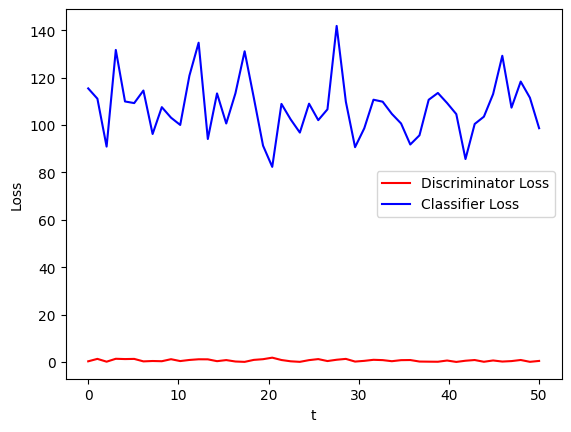

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming D_losses and C_losses are lists of tensors
# Convert them to CPU before plotting
D_losses_cpu = [loss.cpu().detach().numpy() for loss in D_losses]
C_losses_cpu = [loss.cpu().detach().numpy() for loss in C_losses]
D_hinge_losses_cpu = [loss.cpu().detach().numpy() for loss in d_hinge_losses]
# Check the shape of D_losses_cpu and C_losses_cpu
# Reshape t to match the shape of D_losses_cpu and C_losses_cpu
t_d = np.linspace(0, len(D_losses_cpu), len(D_losses_cpu)).reshape(-1, 1)
t_c = np.linspace(0, len(C_losses_cpu), len(C_losses_cpu)).reshape(-1, 1)

#plt.plot(t, D_hinge_losses_cpu, 'k', label='Discriminator\'s Hinge Loss')
plt.plot(t_d, D_losses_cpu, 'r', label='Discriminator Loss')
plt.plot(t_c, C_losses_cpu, 'b', label='Classifier Loss')
plt.xlabel('t')
plt.ylabel('Loss')
plt.legend()
plt.show()


Alternation:



TODO:
- measure the c_loss in each optim step of the d_model
- push c_loss through an activation function
- clean up the code


In [4]:
from biggan_all import Discriminator

d_model = Discriminator(D_ch= 96).cuda()
d_model.load_state_dict(torch.load('/content/drive/MyDrive/biggan/D.pth'))
d_model.eval()

Adding attention layer in D at resolution 64
Param count for Ds initialized parameters: 87982369


Discriminator(
  (activation): ReLU()
  (blocks): ModuleList(
    (0): ModuleList(
      (0): DBlock(
        (activation): ReLU()
        (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (conv1): SNConv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): SNConv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_sc): SNConv2d(3, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): Attention(
        (theta): SNConv2d(96, 12, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (phi): SNConv2d(96, 12, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (g): SNConv2d(96, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (o): SNConv2d(48, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
    (1): ModuleList(
      (0): DBlock(
        (activation): ReLU()
        (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
        (conv1): SNConv2d(96, 192, kernel_size=(3, 3), stride=(1, 1

label:  386


100%|██████████| 200/200 [00:03<00:00, 64.23it/s]


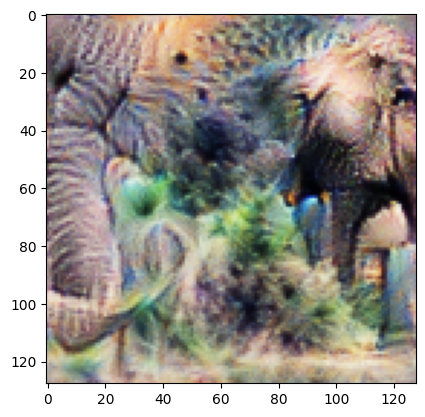

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 100/100 [00:07<00:00, 13.41it/s]


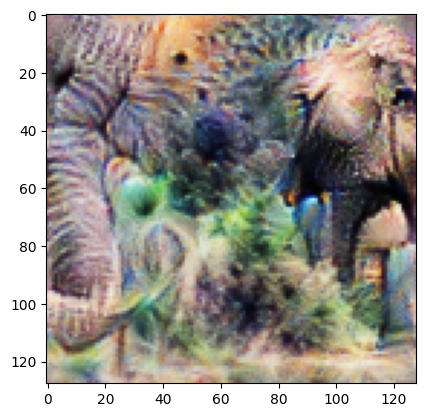

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 200/200 [00:02<00:00, 87.65it/s]


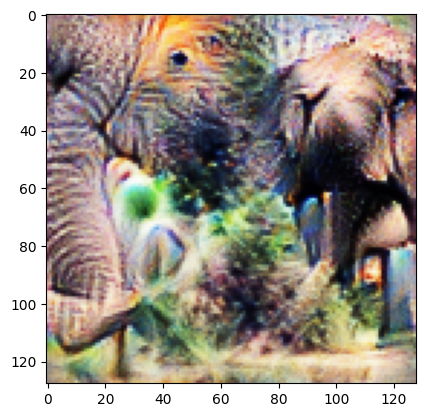

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 100/100 [00:07<00:00, 13.01it/s]


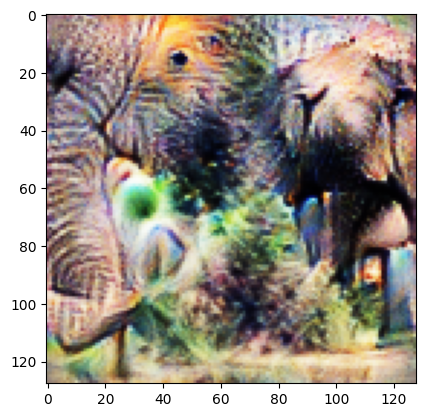

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 200/200 [00:02<00:00, 85.37it/s]


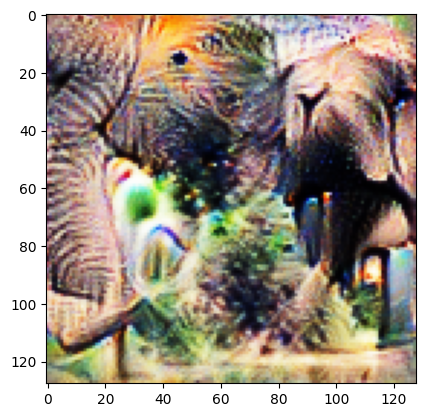

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 100/100 [00:07<00:00, 12.95it/s]


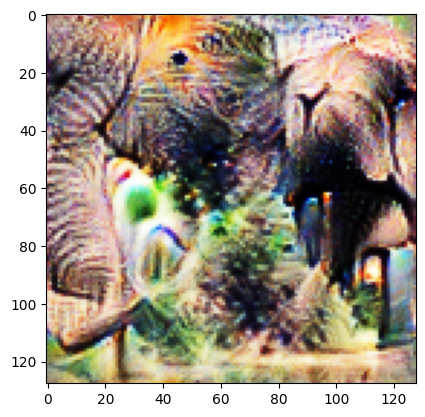

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 200/200 [00:02<00:00, 82.97it/s]


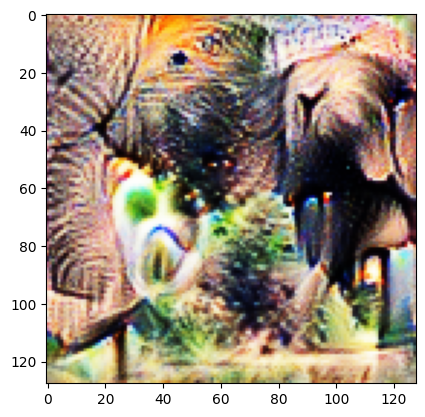

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 100/100 [00:07<00:00, 13.15it/s]


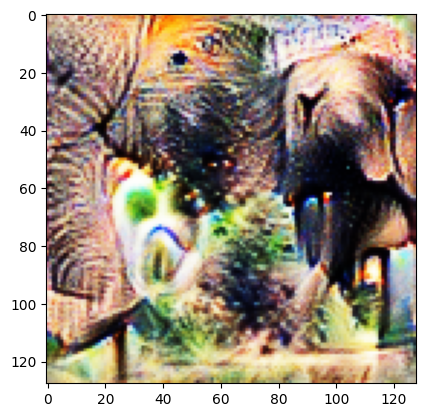

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 200/200 [00:03<00:00, 61.79it/s]


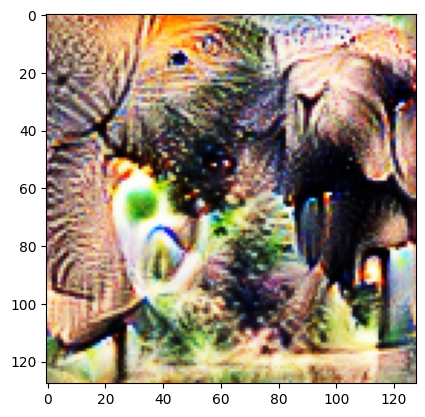

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 100/100 [00:07<00:00, 13.26it/s]


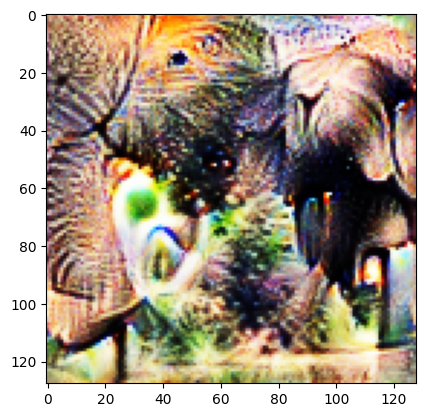

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [107]:
import matplotlib.pyplot as plt
import torchvision.models as models
from torch_dreams import Dreamer
from torch_dreams.custom_image_param import CustomImageParam
from PIL import Image
from biggan_all import Discriminator
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import tensor
from google.colab import files
import numpy as np




#test_class = 1 #goldfish
indices = [1,3,9,13,4,7,22,60,37, 64,77,76,75,74,73,78,84,94]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

t = transforms.Compose([
    #transforms.ToTensor(),
    transforms.Normalize(mean = torch.tensor([0.485, 0.456, 0.406], device='cuda'), std = torch.tensor([0.229, 0.224, 0.225], device='cuda'))
])

t_pil = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = torch.tensor([0.485, 0.456, 0.406], device='cuda'), std = torch.tensor([0.229, 0.224, 0.225], device='cuda'))
])

my_transforms = transforms.Compose([
    transforms.RandomAffine(degrees = 0, translate = (0,0)),
    transforms.RandomHorizontalFlip(p = 0)
])


def loss_hinge_dis(dis_fake):
  loss = torch.mean(F.relu(1. - dis_fake))
  #loss = torch.mean(F.relu(1. + dis_fake))
  return loss

def optimize_single_c_class(layer_outputs):

  output_vector = layer_outputs[0][0]  # Assuming the output is of shape (1, 1000)
  ground_truth_vector = torch.zeros_like(output_vector)
  ground_truth_vector[label] = 1000
  #print('out: ', output_vector)
  #print('ground_truth: ', ground_truth_vector)
  c_loss = torch.norm(output_vector - ground_truth_vector)
  #C_losses.append(c_loss.item())
  #c_loss = layer_outputs[0][0][label].norm()
  #c_loss = torch.sigmoid(loss)
  C_losses.append(c_loss)
  loss = c_loss #isnt it saturated? eg softmax, etc?
  #with torch.no_grad():
  #  d_out = d_model(x=torch.tensor(g_image).to(device)) #d_out = d_model(x = torch.tensor(image).to(device)): #,y = torch.tensor([test_class]).to(device))
  #  d_loss = loss_hinge_dis(d_out)
  #  D_losses.append(d_loss)
  return loss

def optimize_single_d_class(layer_outputs):
  #print(layer_outputs[0])
  d_loss = layer_outputs[0].norm()
  #d_hinge_loss = loss_hinge_dis(layer_outputs[0][0])
  D_losses.append(d_loss)
  loss = d_loss #d_hinge_loss
  return loss

def alternating_gen(image_param=None, alt_nr=4, label=1, c_iters=10, d_iters=10, d_lr=0.01):


  #for a in label_list:
  for r in range(0,alt_nr):
    #param = CustomImageParam(image = image_param, device= 'cuda')
    #rand_tens = torch.randn(1,3,128,128).cuda()
    #image_param = CustomImageParam(image = rand_tens, device= 'cuda')
    dreamy_boi = Dreamer(c_model, device = 'cuda')
    image_param = dreamy_boi.render(
      image_parameter= image_param,
      layers = [c_model.fc],
      width = 128,
      height = 128,
      iters = c_iters,
      grad_clip= 1,
      custom_func = optimize_single_c_class
      )
    plt.imshow(image_param)
    plt.show()

    class_name = imagenet_class_names[label]
    filename = str(label)+'_'+class_name+'_image_after_C_'+str(r)+'.jpg'
    image_param.save(filename)
    files.download(filename)
    losses_dict[label]['C_losses'].extend(C_losses[-c_iters:])
    losses_dict[label]['C_losses'].extend([tensor(np.nan) for a in range(0,d_iters)])


#############################
#SWITCHING TO D OPTIMIZATION#
#############################
    #image_param.save('image'+str(a)+'.jpg')
    #image = Image.open('image'+str(a)+'.jpg')
    #image = torch.tensor(image).permute(-1,0,1).unsqueeze(0)
    #image = t_pil(image).float().cuda().unsqueeze(0)
    #g_image = image
#############################
#SWITCHING TO D OPTIMIZATION#
#############################

    dreamy_boi2 = Dreamer(d_model, device = 'cuda')
      #dreamy_boi2.set_custom_normalization(normalization_transform = t)
      #print(d_model.linear)
    image_param = dreamy_boi2.render(
      image_parameter= image_param,
      #image_parameter= image_param,
      layers = [d_model.linear],
      custom_func = optimize_single_d_class,
      height = 128,
      width = 128,
      iters = d_iters,
      scale_max = 1.,
      scale_min =  1.,
      grad_clip= 0.1,
      lr  = d_lr
      )
    plt.imshow(image_param)
    plt.show()

    class_name = imagenet_class_names[label]
    filename = str(label)+'_'+class_name+'_image_after_D_'+str(r)+'.jpg'
    image_param.save(filename)
    files.download(filename)
    losses_dict[label]['D_losses'].extend(D_losses[-d_iters:])
    if r < alt_nr-1:
      losses_dict[label]['D_losses'].extend([tensor(np.nan) for a in range(0,c_iters)])

losses_dict = {}
d_hinge_losses = []
g_image = None
label_list = list(range(386,387)) #  indices
#rand_tens = torch.randn(1,3,128,128).cuda()
#image_param = CustomImageParam(image = t(rand_tens), device= 'cuda')

#d_model = Discriminator(D_ch= 96).cuda()
#d_model.load_state_dict(torch.load('/content/drive/MyDrive/biggan/D.pth'))
c_model = models.resnet18(pretrained= True).eval()
c_iters = 200
d_iters = 100
#image_param = None
for label in label_list:
  print('label: ', label)
  losses_dict[label] = {'C_losses': [], 'D_losses': [tensor(np.nan) for a in range(0,c_iters)]}
  alternating_gen(image_param=None, alt_nr=5, label=label, c_iters=c_iters, d_iters=d_iters, d_lr=0.01)
  C_losses.clear()
  D_losses.clear()

label:  386
[tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan), tensor(nan),

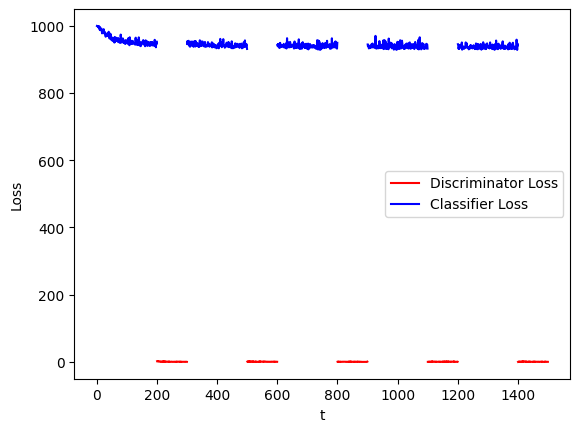

In [108]:
import numpy as np
import matplotlib.pyplot as plt
min_value = 0
max_value = 1.0

def min_max_scale(values):
    min_val = min(values)
    print('min_val: ', min_val)
    min_val = 0
    max_val = max(values)
    scaled_values = [(value - min_val) / (max_val - min_val) for value in values if value is not None]
    return scaled_values


# After you've finished gathering the losses for all labels
# Iterate through the lists and scale values
for label in label_list:
  print('label: ',label)

  #plt.plot(losses_dict[label]['D_losses'])
  #losses_dict[label]['D_losses'] = min_max_scale(losses_dict[label]['D_losses'])
  #losses_dict[label]['C_losses'] = min_max_scale(losses_dict[label]['C_losses'])
  print(losses_dict[label]['D_losses'])



for label in label_list:
  print(label)
  print(len(losses_dict[label]['C_losses']))
  print(len(losses_dict[label]['D_losses']))
  D_losses_cpu = [loss.cpu().detach().numpy() for loss in losses_dict[label]['D_losses']]
  C_losses_cpu = [(loss).cpu().detach().numpy() for loss in losses_dict[label]['C_losses']]
  print(D_losses_cpu)
  #C_losses_cpu = [max(min(value, 1.0), 0.0) for value in C_losses_cpu]
  #D_losses_cpu = [max(min(value, 1.0), 0.0) for value in D_losses_cpu]
  #D_losses_cpu = min_max_scale(D_losses_cpu)
  #D_hinge_losses_cpu = [loss.cpu().detach().numpy() for loss in d_hinge_losses]
  t_d = np.linspace(0, len(D_losses_cpu), len(D_losses_cpu)).reshape(-1, 1)
  t_c = np.linspace(0, len(C_losses_cpu), len(C_losses_cpu)).reshape(-1, 1)

  #plt.plot(t, D_hinge_losses_cpu, 'k', label='Discriminator\'s Hinge Loss')
  plt.plot(t_d, D_losses_cpu, 'r', label='Discriminator Loss')
  plt.plot(t_c, C_losses_cpu, 'b', label='Classifier Loss')
  plt.xlabel('t')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()




In [90]:
print(D_losses_cpu)
for el in D_losses_cpu:
  if el:
    print(el.dtype)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

In [62]:
!wget http://image-net.org/download-images

--2023-08-16 13:58:53--  http://image-net.org/download-images
Resolving image-net.org (image-net.org)... 171.64.68.16
Connecting to image-net.org (image-net.org)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://image-net.org/download-images [following]
--2023-08-16 13:58:53--  https://image-net.org/download-images
Connecting to image-net.org (image-net.org)|171.64.68.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6012 (5.9K) [text/html]
Saving to: ‘download-images’

download-images     100%[===================>]   5.87K  --.-KB/s    in 0s      

2023-08-16 13:58:53 (243 MB/s) - ‘download-images’ saved [6012/6012]



In [61]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageNet
from torchvision.datasets.utils import download_url

# Load the pre-trained ResNet-18 model
resnet = models.resnet18(pretrained=True)
resnet.eval()

# Define the transform for preprocessing images
normalize = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the ImageNet dataset

    # Download and prepare the ImageNet dataset
download_url('http://www.image-net.org/challenges/LSVRC/2012/nnoupb/ILSVRC2012_img_val.tar', 'path/to/save')
imagenet_dataset = ImageNet(root='path/to/save', split='val', transform=normalize)

# Create a dictionary to store average layer outputs
average_layer_outputs = {}

# Loop through the ImageNet dataset
for image, label in imagenet_dataset:
    # Get the model's output for the current image
    output = resnet(image.unsqueeze(0))  # Batch size of 1

    # Get the output of the desired layer (change the layer index as needed)
    desired_layer_output = output[layer_index]  # Change layer_index to the desired layer

    # Accumulate the layer outputs for averaging
    if label in average_layer_outputs:
        average_layer_outputs[label] += desired_layer_output
    else:
        average_layer_outputs[label] = desired_layer_output

# Divide the accumulated layer outputs by the number of images per class to get the average
for label in average_layer_outputs:
    average_layer_outputs[label] /= imagenet_dataset.targets.count(label)

# The dictionary "average_layer_outputs" now contains the average output vectors for each ImageNet class


HTTPError: ignored

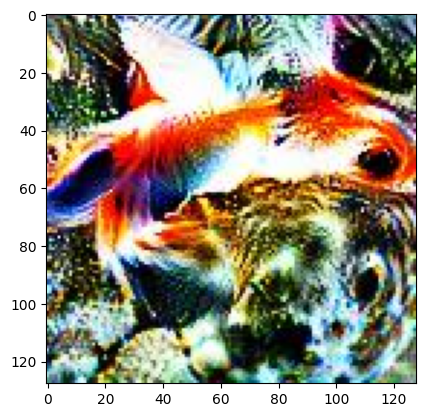

In [12]:
my_transforms = transforms.Compose([
    transforms.RandomAffine(degrees = 0, translate = (0,0)),
    transforms.RandomHorizontalFlip(p = 0.5)
])


image = Image.open('image.jpg')
img = my_transforms(image)

plt.imshow(img)
plt.show()

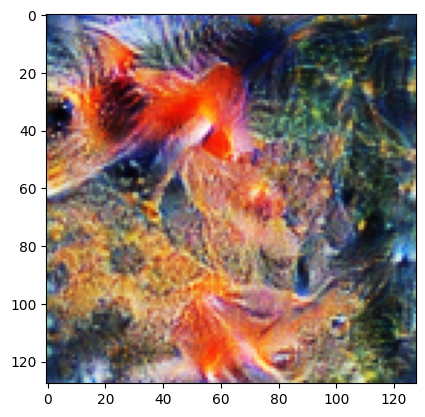

In [13]:
plt.imshow(image_param)
plt.show()


Another minimal example of BigGAN's discriminator's forward pass

In [ ]:
import torch.optim as optim

#def loss_hinge_dis(dis_fake):
#  loss_fake = torch.mean(F.relu(1. + dis_fake))
#  return loss_fake

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Discriminator(D_ch= 96).cuda()
model.load_state_dict(torch.load('/content/drive/MyDrive/biggan/D.pth'))
#model = Discriminator(D_ch= 96)
#model.load_state_dict(torch.load('/content/drive/MyDrive/biggan/D.pth'))
#model = model.cuda().eval()

In [25]:


input_image_tensor = torch.randn(1,3,128,128).cuda()
input_image_tensor.requires_grad = True



output = model(x = input_image_tensor,y = torch.tensor([386]).to(device))
model.optim = optim.Adam(params=[input_image_tensor], lr=0.02, betas=(0.0, 0.999), weight_decay=0, eps=1e-8)
#model.train()
l = loss_hinge_dis(output)
print(l)
l.backward()
print(input_image_tensor.grad)

tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')


SNLinear(in_features=1536, out_features=1, bias=True)
  0%|          | 0/100 [00:00<?, ?it/s]tensor([[-4.2313]], device='cuda:0', grad_fn=<AddmmBackward0>)
  1%|          | 1/100 [00:00<00:24,  4.06it/s]